## Load AudioSet data from file

Data extracted by:
https://github.com/qiuqiangkong/audioset_classification

In [98]:
import h5py
import numpy as np

feat_dir = "./features/"
models_dir = "./models/"
hdf5_path = "../dataset/packed_features"

def load_data(hdf5_path):
    with h5py.File(hdf5_path, 'r') as hf:
        x = hf.get('x')
        y = hf.get('y')
        video_id_list = hf.get('video_id_list')
        x = np.array(x)
        y = list(y)
        video_id_list = list(video_id_list)
        
    return x, y, video_id_list

def uint8_to_float32(x):
    return (np.float32(x) - 128.) / 128.
    
def bool_to_float32(y):
    return np.float32(y)

(x_train, y_train, train_video_id_list) = load_data(hdf5_path+"/bal_train.h5")
(x_eval, y_eval, eval_video_id_list) = load_data(hdf5_path+"/eval.h5")
(x_unbal, y_unbal, unbal_video_id_list) = load_data(hdf5_path+"/unbal_train.h5")

In [99]:
#Convert
x_train = uint8_to_float32(x_train)		# shape: (N, 10, 128)
y_train = np.array(y_train).astype(int)			# shape: (N, 527)
x_eval = uint8_to_float32(x_eval)
y_eval = np.array(y_eval).astype(int)
x_unbal = uint8_to_float32(x_unbal)
y_unbal = np.array(y_unbal).astype(int)

In [100]:
# Select the classes we want
import pandas as pd

classes_file = "../dataset/class_labels_indices.csv"

df = pd.read_csv(classes_file)
df = df.set_index('index')
selected_classes = ["Vehicle horn, car horn, honking", "Children playing", "Dog", "Jackhammer", "Siren", 
                    "Traffic noise, roadway noise", "Subway, metro, underground", "Walk, footsteps", "Chatter", "Bird"]

df_sel = df[df['display_name'].isin(selected_classes)]
df_sel.head(10)

,mid,display_name
index,,
53,/m/07pbtc8,"Walk, footsteps"
68,/m/07rkbfh,Chatter
71,/t/dd00013,Children playing
74,/m/0bt9lr,Dog
111,/m/015p6,Bird
308,/m/0912c9,"Vehicle horn, car horn, honking"
327,/m/0btp2,"Traffic noise, roadway noise"
334,/m/0195fx,"Subway, metro, underground"
396,/m/03kmc9,Siren


In [116]:
filter_classes = list(df_sel.index)

y_train_filtered = y_train[:,filter_classes]

# Rows that contain only ONE of our classes (There are 264 datapints with 2 classes or more)
filter = np.argwhere(np.sum(y_train_filtered, axis=1) == 1)
y_train = y_train_filtered[filter.flat]
x_train = x_train[filter.flat]

y_eval_filtered = y_eval[:,filter_classes]

filter = np.argwhere(np.sum(y_eval_filtered, axis=1) == 1)
y_eval = y_eval_filtered[filter.flat]
x_eval = x_eval[filter.flat]

y_unbal_filtered = y_unbal[:,filter_classes]

filter = np.argwhere(np.sum(y_unbal_filtered, axis=1) == 1)
y_unbal = y_unbal_filtered[filter.flat]
x_unbal = x_unbal[filter.flat]

In [124]:
X = np.concatenate((x_train, x_unbal))
y = np.concatenate((y_train, y_unbal))

In [130]:
import keras
from keras import callbacks
from tensorflow.keras.layers import Dense, Dropout, Input, BatchNormalization, Activation, Lambda
import keras.backend as K
import tensorflow as tf

def auroc(y_true, y_pred):
    return tf.numpy_function(roc_auc_score, (y_true, y_pred), tf.double)

def attention_pooling(inputs, **kwargs):
    [out, att] = inputs

    epsilon = 1e-7
    att = K.clip(att, epsilon, 1. - epsilon)
    normalized_att = att / K.sum(att, axis=1)[:, None, :]

    return K.sum(out * normalized_att, axis=1)

def pooling_shape(input_shape):

    if isinstance(input_shape, list):
        (sample_num, time_steps, freq_bins) = input_shape[0]

    else:
        (sample_num, time_steps, freq_bins) = input_shape

    return (sample_num, freq_bins)

time_steps = 10
freq_bins = 128
classes_num = 10

# Hyper parameters
hidden_units = 1024
drop_rate = 0.5
batch_size = 500

# Embedded layers
input_layer = Input(shape=X[0].shape)

a1 = Dense(hidden_units)(input_layer)
a1 = BatchNormalization()(a1)
a1 = Activation('relu')(a1)
a1 = Dropout(drop_rate)(a1)

a2 = Dense(hidden_units)(a1)
a2 = BatchNormalization()(a2)
a2 = Activation('relu')(a2)
a2 = Dropout(drop_rate)(a2)

a3 = Dense(hidden_units)(a2)
a3 = BatchNormalization()(a3)
a3 = Activation('relu')(a3)
a3 = Dropout(drop_rate)(a3)
cla = Dense(hidden_units, activation='linear')(a3)
att = Dense(hidden_units, activation='sigmoid')(a3)

b1 = Lambda(attention_pooling, output_shape=pooling_shape)([cla, att])
b1 = BatchNormalization()(b1)
b1 = Activation(activation='relu')(b1)
b1 = Dropout(drop_rate)(b1)

output_layer = Dense(classes_num, activation='sigmoid')(b1)

model = keras.Model(inputs=input_layer, outputs=output_layer, name="qiuqiangkong")
model.compile(loss='binary_crossentropy', optimizer="Adam", metrics=["accuracy"])
model.summary()

Model: "qiuqiangkong"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 10, 128)]    0           []                               
                                                                                                  
 dense_12 (Dense)               (None, 10, 1024)     132096      ['input_3[0][0]']                
                                                                                                  
 batch_normalization_8 (BatchNo  (None, 10, 1024)    4096        ['dense_12[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_8 (Activation)      (None, 10, 1024)     0           ['batch_normalization_

In [131]:
earlystopping = callbacks.EarlyStopping(monitor ="val_loss", 
                                        mode ="min", patience = 10, 
                                        restore_best_weights = True)


history = model.fit(
    X,
    y,
    batch_size=64, # batch size 1 doesn't work
    epochs=100,
    validation_data=(x_eval, y_eval),
    callbacks =[earlystopping]
)

Epoch 1/100
929/929 [==============================] - 115s 121ms/step - loss: 0.1099 - accuracy: 0.7872 - val_loss: 0.1225 - val_accuracy: 0.7521
Epoch 2/100
929/929 [==============================] - 108s 117ms/step - loss: 0.0902 - accuracy: 0.8189 - val_loss: 0.1092 - val_accuracy: 0.7968
Epoch 3/100
929/929 [==============================] - 93s 100ms/step - loss: 0.0864 - accuracy: 0.8291 - val_loss: 0.0952 - val_accuracy: 0.8089
Epoch 4/100
929/929 [==============================] - 90s 97ms/step - loss: 0.0832 - accuracy: 0.8343 - val_loss: 0.0992 - val_accuracy: 0.7959
Epoch 5/100
929/929 [==============================] - 113s 122ms/step - loss: 0.0816 - accuracy: 0.8381 - val_loss: 0.0976 - val_accuracy: 0.8108
Epoch 6/100
929/929 [==============================] - 99s 106ms/step - loss: 0.0801 - accuracy: 0.8418 - val_loss: 0.0972 - val_accuracy: 0.8043
Epoch 7/100
929/929 [==============================] - 88s 95ms/step - loss: 0.0782 - accuracy: 0.8451 - val_loss: 0.0942 

In [132]:
models_dir = "./models/"

model.save_weights(f"{models_dir}qiuqiangkong_b64_hdf5_weights.tf")

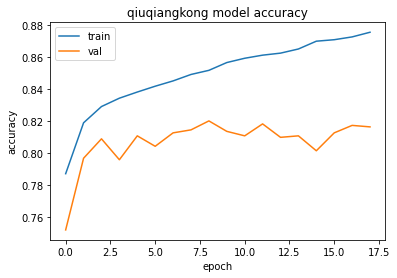

In [133]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('qiuqiangkong model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

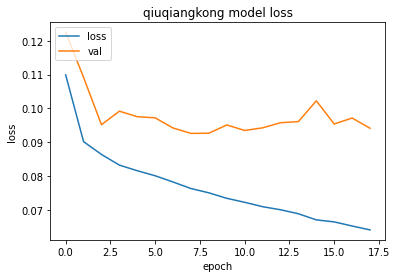

In [134]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('qiuqiangkong model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val'], loc='upper left')
plt.show()

In [135]:
# Generate predictions
y_pred = model.predict(x_eval)

In [136]:
# Transform one hot encoding to a series of ints for confusion matrix

y_pred = np.argmax(y_pred, axis=1)
y_eval_transformed = np.argmax(y_eval, axis=1)

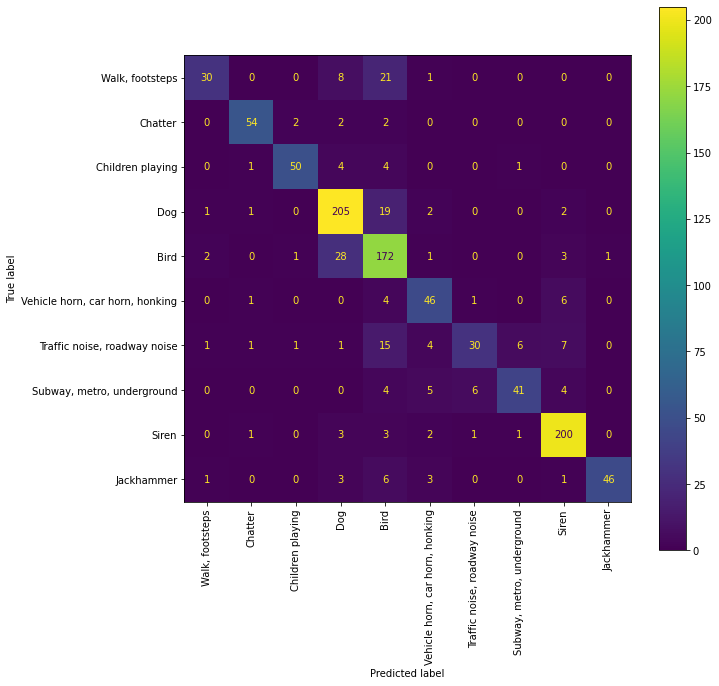

In [149]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


fig, ax = plt.subplots(figsize=(10,10))
disp = ConfusionMatrixDisplay.from_predictions(y_eval_transformed, y_pred, display_labels=[df.iloc[y]["display_name"] for y in filter_classes], 
                              xticks_rotation='vertical', ax=ax)